<h1>SVD decomposition with SciPy</h1>

In [3]:
#Import the required modules
import scipy.linalg as la
import numpy as np

#Generate a 5x4 matrix
np.random.seed(0) #Generate the same random numbers each time
A = np.random.rand(5,4)

Input: a matrix $A$ of size $m \times n$. <br>
Oputput: U of size $m \times m$, S of size $m \times n$ and V of size $n \times n$ <br>
or, more precisely,<br>
σ of size q<br>
where q = min(m,n)

In [17]:
U, s, VT = np.linalg.svd(A)
print("U shape", U.shape)
print("s shape", s.shape)
print("VT shape", VT.shape)

U shape (5, 5)
s shape (4,)
VT shape (4, 4)


In [18]:
#Build the matrix S
S = np.zeros(A.shape)
for i in range(len(s)):
    S[i,i] = s[i]
S

array([[2.64618677, 0.        , 0.        , 0.        ],
       [0.        , 0.83351254, 0.        , 0.        ],
       [0.        , 0.        , 0.70753001, 0.        ],
       [0.        , 0.        , 0.        , 0.29842614],
       [0.        , 0.        , 0.        , 0.        ]])

In [19]:
S = la.diagsvd(s, A.shape[0], A.shape[1])
S

array([[2.64618677, 0.        , 0.        , 0.        ],
       [0.        , 0.83351254, 0.        , 0.        ],
       [0.        , 0.        , 0.70753001, 0.        ],
       [0.        , 0.        , 0.        , 0.29842614],
       [0.        , 0.        , 0.        , 0.        ]])

In [20]:
#Reconstruct the matrix A
A_svd = np.matmul(U, np.matmul(S, VT))
#Equivalently: A_svd = U @ S @ VT
print(f"err: {(la.norm(A-A_svd)/la.norm(A))}")

err: 4.2743316456409587e-16


<h3>A note on vectorization</h3>
Vectorization refers to the practice of replacing explicit loops with high-level mathematical operations that act on entire arrays of matrices at once. This leads to much better performance because it replaces slow Python loops with fast, optimized C and Fortran operations.<br>
Indeed, we could be inclined to reconstruct A_k with a for loop and the explicit formula

$$
A_k = \sum_{i=1}^{k} \sigma_{k} u_{k} v_{k}^{T}
$$

Let's measure the time taken for this operation for a matrix A that is a bit larger.

In [24]:
import time

A = np.random.rand(500, 400)
U, s, VT = la.svd(A, full_matrices=False)
S = np.diag(s)

#Time the reconstruction with a for loop
start_time = time.time()
A_reconstructed_loop = np.zeros_like(A) #Initialize a matrix of zeros
for i in range(len(s)):
    A_reconstructed_loop += s[i] * np.outer(U[:,i], VT[i,:])
loop_time = time.time() - start_time

#Time the reconstruction using matrix multiplication
start_time = time.time()
#Here we are using broadcasting to avoid the creation of a diagonal matrix
A_reconstructed_vectorized = (U * s) @ VT
vectorized_time = time.time() - start_time

#We compare the results
print(f"Time for reconstruction using for loop: {loop_time:.6f} seconds")
print(f"Time for vectorized reconstruction: {vectorized_time:.6f} seconds")
print(f"Vectorized is {loop_time/vectorized_time:.1f} times faster than the loop")

difference = np.abs(A_reconstructed_loop - A_reconstructed_vectorized).max()
print(f"Max difference between the two reconstructions: {difference:.6e}")

Time for reconstruction using for loop: 0.107924 seconds
Time for vectorized reconstruction: 0.000752 seconds
Vectorized is 143.5 times faster than the loop
Max difference between the two reconstructions: 8.881784e-16


<h1>Image compression through SVD</h1>

(np.float64(-0.5), np.float64(799.5), np.float64(462.5), np.float64(-0.5))

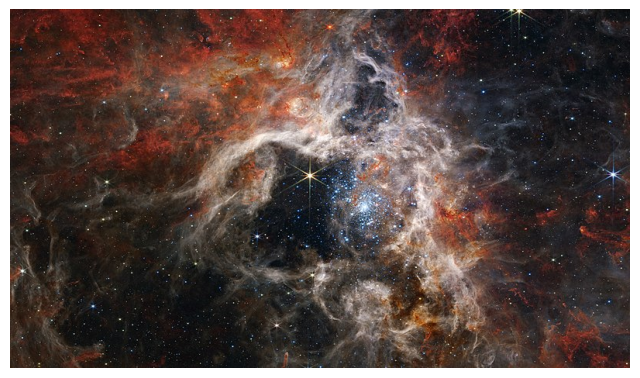

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [8, 8]
image_path = "TarantulaNebula.jpg"
A = imread(image_path)

#Visualize the picture
img = plt.imshow(A)
plt.axis("off")

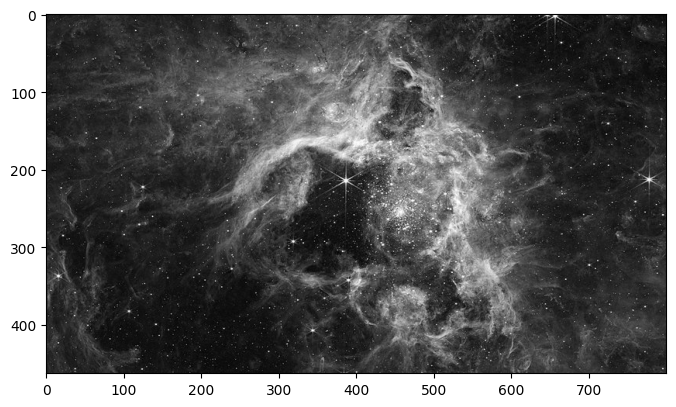

In [8]:
#Convert the picture to gray-scale and visualize it
X = np.mean(A, axis=2)
X.shape
plt.imshow(X, cmap="gray")

In [9]:
#What is the picture size?
X.shape

(463, 800)

In [11]:
#Perform the SVD
U, s, VT = np.linalg.svd(X, full_matrices=False)
U.shape, s.shape, VT.shape

((463, 463), (463,), (463, 800))

Plot the trend of<br>
- The singluar values $\sigma_{k}$<br>
- The cumulate fraction of singular vaues: $\frac{\sum_{i=1}^{k} \sigma_{i}}{\sum_{i=1}^{q} \sigma_{i}}$<br>
- The fraction of the "explained variance": $\frac{\sum_{i=1}^{k} \sigma_{i}^2}{\sum_{i=1}^{q} \sigma_{i}^2}$<br>

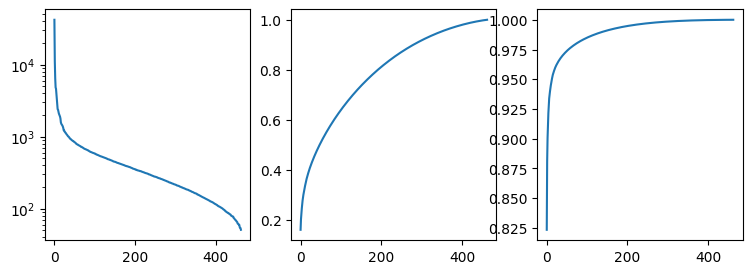

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].semilogy(s)
axs[1].plot(np.cumsum(s)/np.sum(s))
axs[2].plot(np.cumsum(s**2)/np.sum(s**2))

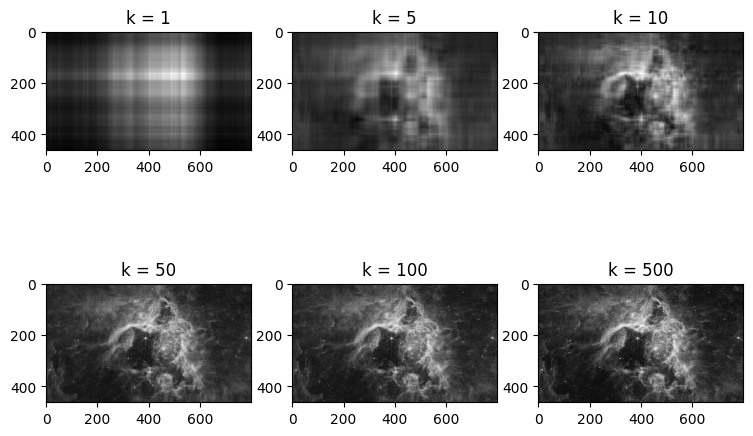

In [26]:
#Visualize the best rank-k matrices, for k = 1, 5, 10, 50, 100, 500
ks = [1, 5, 10, 50, 100, 500]
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
axs = axs.reshape((-1,))
for i, k in enumerate(ks):
    X_k = (U[:, :k] * s[:k]) @ VT[:k, :]
    axs[i].imshow(X_k, cmap="gray")
    axs[i].set_title(f"k = {k}")

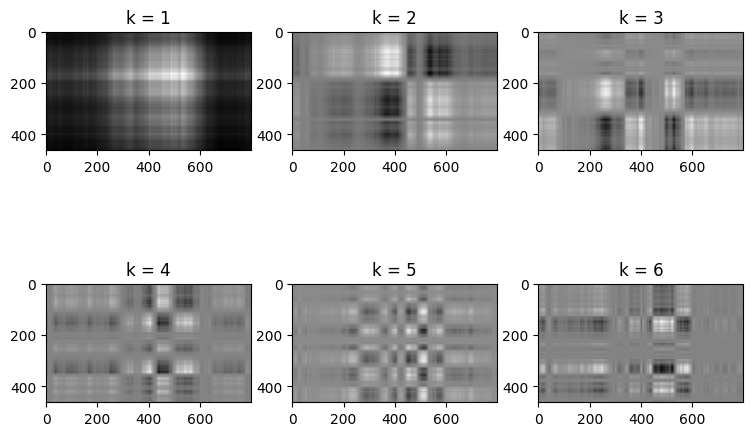

In [29]:
#Visualize the k-th rank-1 matrix, for k = 1, 2, ..., 6
ks = [1, 2, 3, 4, 5, 6]
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
axs = axs.reshape((-1,))
for i, k in enumerate(ks):
    ukvk = np.outer(U[:, k-1], VT[k-1, :])
    axs[i].imshow(ukvk, cmap="gray")
    axs[i].set_title(f"k = {k}")

<h1>Geometric interpretation of PCA</h1>

In [38]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

Define the unit vector
$
v_1 = 
\begin{pmatrix}
\cos(\theta_1) \\
\sin(\theta_1)
\end{pmatrix}
$
where $\theta = \frac{\pi}{6}$ and a unit vector $v_2$ orthogonal to $v_1$.<br>

In [44]:
theta1 = np.pi/6
v1 = np.array([np.cos(theta1), np.sin(theta1)])
theta2 = theta1 + np.pi/2
v2 = np.array([np.cos(theta2), np.sin(theta2)])

Define the point 
$b =
\begin{pmatrix}
20 \\
30
\end{pmatrix}
$

In [45]:
b = np.array([20, 30])

Generate n = 1000 points $x_i$ according to the formula:
$$
x_i = b + r_{1,i}\rho_1 v_1 + r_{2,i}\rho_2 v_2
$$
where $\rho_1 = 12, \rho_2 = 3$ and the $r_{i,j}$ are real numbers independently generated according to a normal distribution.

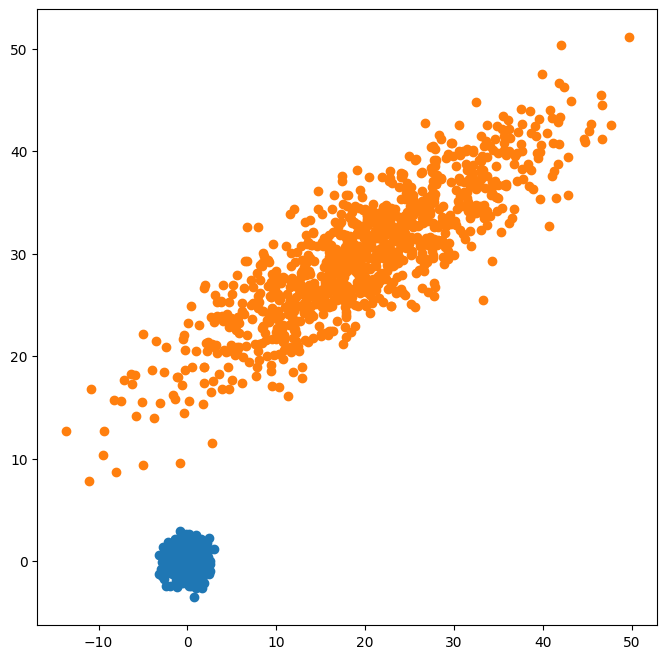

In [ ]:
n = 1000
r = np.random.randn(2, n)
plt.scatter(r[0, :], r[1, :])

# X.shape == (2, n)

rho1 = 12
rho2 = 3

X = b[:, np.newaxis] + rho1 * np.outer(v1, r[0, :]) + rho2 * np.outer(v2, r[1, :])

v1v2 = np.stack([rho1 * v1, rho2 * v2], axis=1)
X = b[:, np.newaxis] + v1v2 @ r

plt.scatter(X[0, :], X[1, :])

Plot the generated numbers in a plane, showing the directions $v_1$ and $v_2$, rescaled by $\rho_1$ and $\rho_2$ respectively.

(np.float64(-16.885104444568213),
 np.float64(52.869373038487154),
 np.float64(5.673103929613559),
 np.float64(53.26863450082991))

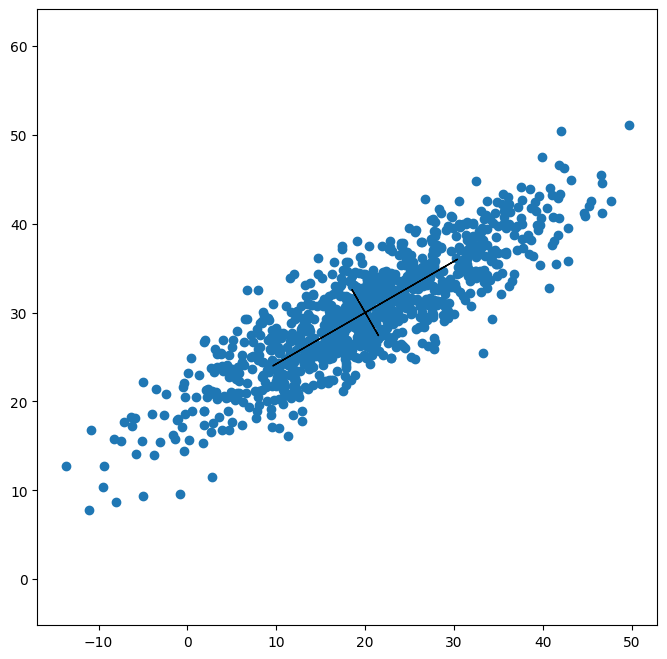

In [68]:
plt.scatter(X[0, :], X[1, :])
plt.arrow(b[0] - rho1 * v1[0], b[1] - rho1 * v1[1], 2 * rho1 * v1[0], 2 * rho1 * v1[1])
plt.arrow(b[0] - rho2 * v2[0], b[1] - rho2 * v2[1], 2 * rho2 * v2[0], 2 * rho2 * v2[1])
plt.axis("equal")

Perform PCA on the matrix $X \in \mathbb{R}^{2 \times n}$
$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i \\
\overline{X} = X - \mu[1, \ldots, 1] \\
\overline{X} = U \Sigma V^T
$$

In [70]:
X_mean = np.mean(X, axis=1)
X_bar = X- X_mean[:, np.newaxis]
U, s, VT = np.linalg.svd(X_bar, full_matrices=False)

Plot the first two singular vectors, rescaled by the root of the sample variance:
$$
\sqrt{\frac{\sigma_1^2}{(n-1)}}u_1,
\sqrt{\frac{\sigma_2^2}{(n-1)}}u_2
$$

(array([0.8660254, 0.5      ]),
 array([-0.5      ,  0.8660254]),
 array([-0.86911523, -0.49460966]),
 array([-0.49460966,  0.86911523]))

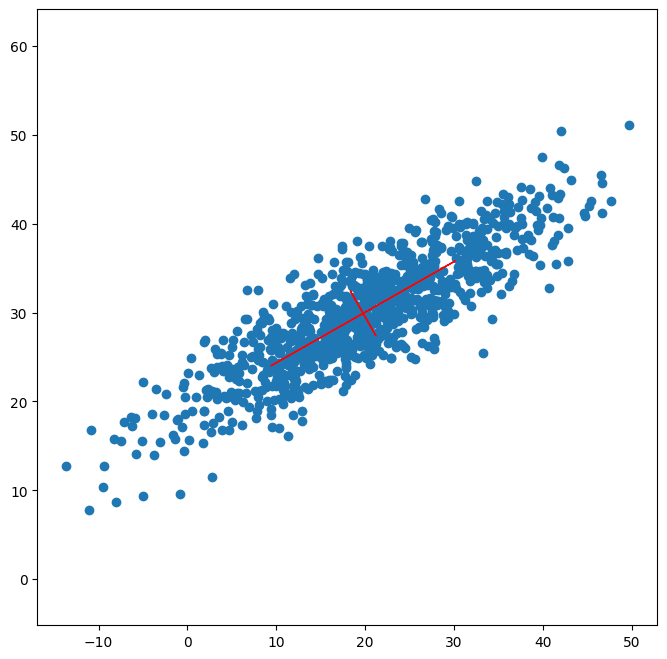

In [73]:
u1 = U[:, 0]
u2 = U[:, 1]

r = s / np.sqrt(n - 1)

plt.scatter(X[0, :], X[1, :])
plt.arrow(X_mean[0] - r[0] * u1[0], X_mean[1] - r[0] * u1[1], 2 * r[0] * u1[0], 2 * r[0] * u1[1], color="r")
plt.arrow(X_mean[0] - r[1] * u2[0], X_mean[1] - r[1] * u2[1], 2 * r[1] * u2[0], 2 * r[1] * u2[1], color="r")
plt.axis("equal")

v1, v2, u1, u2

Complete the principal components of the data:
$$
\Phi = U^T \overline{X}
$$

In [74]:
Phi = U.T @ X_bar

Make a scatterplot of the two first principal components $(\Phi_1, \Phi_2)$

(np.float64(-40.20582252635705),
 np.float64(41.45772521145882),
 np.float64(-11.550529275687676),
 np.float64(9.765358450166293))

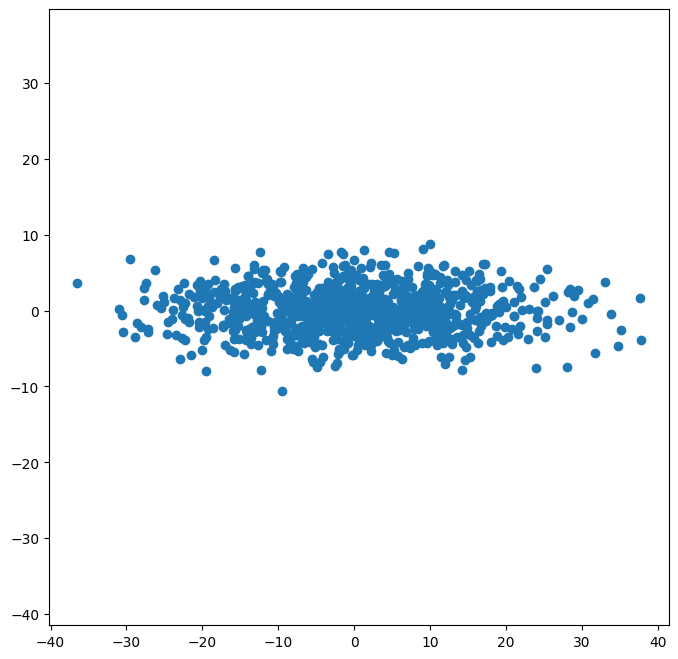

In [76]:
plt.scatter(Phi[0, :], Phi[1, :])
plt.axis("equal")